# Classifying Penguins with Decision Trees

Load the penguins dataset - as before, we'll use Seaborn dataset:

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
penguins_df = sns.load_dataset("penguins")
penguins_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [3]:
len(penguins_df)

344

In [4]:
penguins_df.describe().T

,count,mean,std,min,25%,50%,75%,max
bill_length_mm,342.0,43.921930,5.459584,32.1,39.225,44.45,48.5,59.6
bill_depth_mm,342.0,17.151170,1.974793,13.1,15.600,17.30,18.7,21.5
flipper_length_mm,342.0,200.915205,14.061714,172.0,190.000,197.00,213.0,231.0
body_mass_g,342.0,4201.754386,801.954536,2700.0,3550.000,4050.00,4750.0,6300.0


In [5]:
penguins_df.isnull().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
dtype: int64

We've spotted some missing values. For this example we'll just get rid of rows with missing values.

In [6]:
penguins_df = penguins_df.dropna()

In [7]:
len(penguins_df)

333

Let's get a quick visual on the relationship between all pairs of numeric columns.

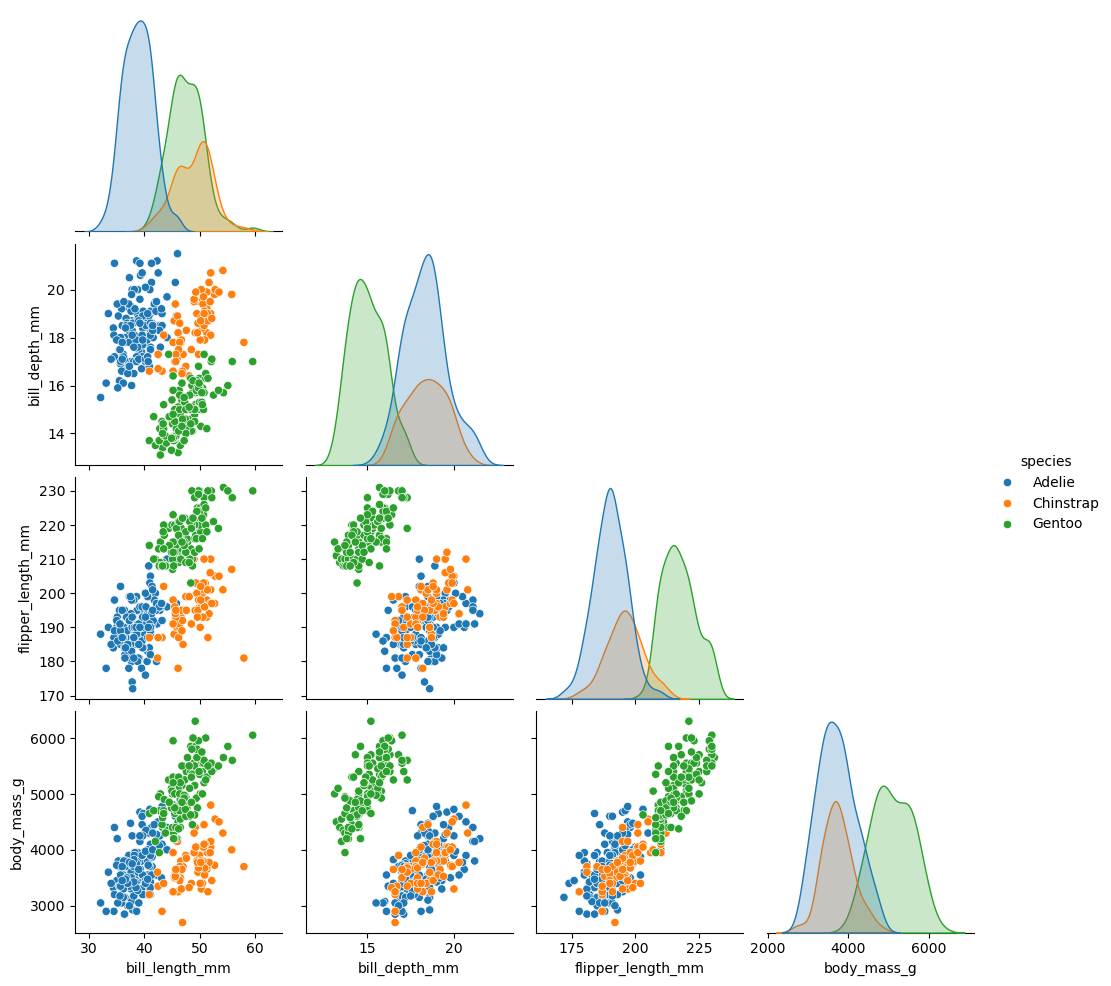

In [8]:
sns.pairplot(data=penguins_df,
             hue="species",
             corner=True)

## Using a Decision Tree Classifier to Predict Penguin Species

In [9]:
penguins_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


### Encode categorical variables

The species, island, and sex variables are strings. This will cause a problem for our decision tree classifier which **works with numeric variables**. To solve this, we'll need to encode those variables. 

See: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder.fit_transform, https://scikit-learn.org/stable/modules/preprocessing_targets.html and https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#sklearn.preprocessing.OrdinalEncoder

The species is our label, so we'll use a LabelEncoder for that.

In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

Let's first make a quick DataFrame with two columns: the original penguin species and it's new encoded value.

In [11]:
encoding_df = pd.DataFrame({"species": penguins_df["species"],
                            "species_encoded": label_encoder.fit_transform(penguins_df["species"])})

In [12]:
encoding_df.sample(10)

,species,species_encoded
190,Chinstrap,1
172,Chinstrap,1
195,Chinstrap,1
34,Adelie,0
78,Adelie,0
208,Chinstrap,1
156,Chinstrap,1
293,Gentoo,2
119,Adelie,0
95,Adelie,0


Now we'll replace the original text based penguin species label with it's numerically encoded version which will be compatible with our machine learning models.

In [13]:
penguins_df['species'] = label_encoder.fit_transform(penguins_df['species'])

We can convert the male/female values in the sex column using an OrdinalEncoder. This will change them to 0 and 1.

In [14]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()

Again, let's make a quick DataFrame to show the encoded values.

In [15]:
encoded_df = pd.DataFrame({"sex": penguins_df["sex"]})
encoded_df[['encoded_value']] = ordinal_encoder.fit_transform(encoded_df[['sex']])

encoded_df.head()

,sex,encoded_value
0,Male,1.0
1,Female,0.0
2,Female,0.0
4,Female,0.0
5,Male,1.0


Now we'll go ahead and update the penguins sex column with the numerically encoded values.

In [16]:
penguins_df[['sex']] = ordinal_encoder.fit_transform(penguins_df[['sex']])

In [17]:
penguins_df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,0,Torgersen,39.1,18.7,181.0,3750.0,1.0
1,0,Torgersen,39.5,17.4,186.0,3800.0,0.0
2,0,Torgersen,40.3,18.0,195.0,3250.0,0.0
4,0,Torgersen,36.7,19.3,193.0,3450.0,0.0
5,0,Torgersen,39.3,20.6,190.0,3650.0,1.0


It makes more sense to use a OneHotEncoder for our island column. As we'll see, this will make our decision tree more readable as we'll avoid questions like "Is the island less than 2?". Instead, we'll get three columns for island with a 1 in the column that corresponds to the original island value, and 0s for the other two.

In [18]:
from sklearn.preprocessing import OneHotEncoder

In [19]:
one_hot_encoder = OneHotEncoder()

island_encoded = one_hot_encoder.fit_transform(penguins_df[['island']])

The OneHotEncoder has given us a sparse matrix.

In [20]:
island_encoded

<333x3 sparse matrix of type '<class 'numpy.float64'>'
	with 333 stored elements in Compressed Sparse Row format>

Before converting this to a Pandas DataFrame, we need to convert it to a dense array.

In [21]:
island_encoded = island_encoded.toarray()

island_encoded

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

Now we can convert the one-hot encoded 'island' result to a DataFrame.

In [22]:
island_encoded_df = pd.DataFrame(
    island_encoded, columns=one_hot_encoder.get_feature_names_out(['island'])
)

island_encoded_df

,island_Biscoe,island_Dream,island_Torgersen
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0
...,...,...,...
328,1.0,0.0,0.0
329,1.0,0.0,0.0
330,1.0,0.0,0.0
331,1.0,0.0,0.0


We now bring the new one-hot encoded 'island' columns into the original DataFrame and drop the redundant 'island' column.


In [23]:
penguins_df = pd.concat([penguins_df, island_encoded_df],
                        axis=1,  # axis=1 for columns
                        join='inner')  # without this we'll introduce NaNs

In [24]:
penguins_df = penguins_df.drop(columns=['island'])

Now when we check out our DataFrame, we'll see that species, island, and sex are now encoded with numeric values.

In [25]:
penguins_df.sample(15)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,island_Biscoe,island_Dream,island_Torgersen
209,1,49.3,19.9,203.0,4050.0,1.0,0.0,1.0,0.0
99,0,43.2,18.5,192.0,4100.0,1.0,1.0,0.0,0.0
309,2,52.1,17.0,230.0,5550.0,1.0,1.0,0.0,0.0
144,0,37.3,16.8,192.0,3000.0,0.0,0.0,1.0,0.0
27,0,40.5,17.9,187.0,3200.0,0.0,0.0,1.0,0.0
295,2,48.6,16.0,230.0,5800.0,1.0,1.0,0.0,0.0
136,0,35.6,17.5,191.0,3175.0,0.0,0.0,1.0,0.0
20,0,37.8,18.3,174.0,3400.0,0.0,1.0,0.0,0.0
259,2,48.7,15.7,208.0,5350.0,1.0,1.0,0.0,0.0
254,2,49.1,14.8,220.0,5150.0,0.0,1.0,0.0,0.0


## Training and test data

### Define X and y
We want to be able to predict a penguin's species from the observations about that penguin - the "features". Our target variable is species, which is conventionally called y. The features are conventionally called X (upper case).

In [26]:
X = penguins_df.drop('species', axis=1)
y = penguins_df['species']

In [27]:
X.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,island_Biscoe,island_Dream,island_Torgersen
0,39.1,18.7,181.0,3750.0,1.0,0.0,0.0,1.0
1,39.5,17.4,186.0,3800.0,0.0,0.0,0.0,1.0
2,40.3,18.0,195.0,3250.0,0.0,0.0,0.0,1.0
4,36.7,19.3,193.0,3450.0,0.0,0.0,0.0,1.0
5,39.3,20.6,190.0,3650.0,1.0,0.0,0.0,1.0


In [28]:
y.head()

0    0
1    0
2    0
4    0
5    0
Name: species, dtype: int32

### Split the dataset into training and testing sets
We are going to build our decision tree using the penguin data, but we'll set aside some of that data so that we can test how accurate our decision tree is on examples that weren't usef in its construction. For this we can use the train_test_split function.

In [29]:
from sklearn.model_selection import train_test_split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42)

In [31]:
X_train.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,island_Biscoe,island_Dream,island_Torgersen
268,44.9,13.3,213.0,5100.0,0.0,1.0,0.0,0.0
87,36.9,18.6,189.0,3500.0,0.0,0.0,1.0,0.0
154,51.3,19.2,193.0,3650.0,1.0,0.0,1.0,0.0
44,37.0,16.9,185.0,3000.0,0.0,1.0,0.0,0.0
229,46.8,15.4,215.0,5150.0,1.0,1.0,0.0,0.0


In [32]:
y_train.head()

268    2
87     0
154    1
44     0
229    2
Name: species, dtype: int32

In [33]:
y_train.isnull().sum()

0

In [34]:
X_test.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,island_Biscoe,island_Dream,island_Torgersen
138,37.0,16.5,185.0,3400.0,0.0,0.0,1.0,0.0
114,39.6,20.7,191.0,3900.0,0.0,0.0,0.0,1.0
143,40.7,17.0,190.0,3725.0,1.0,0.0,1.0,0.0
14,34.6,21.1,198.0,4400.0,1.0,0.0,0.0,1.0
186,49.7,18.6,195.0,3600.0,1.0,0.0,1.0,0.0


In [35]:
y_test.head()

138    0
114    0
143    0
14     0
186    1
Name: species, dtype: int32

## Create our decision tree
Scikit-learn makes this very easy for us with the DecisionTreeClassifier and its fit method.

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
clf = DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

Now we use the classifier to predict species in the test set and calculate accuracy

In [38]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 0, 2, 1, 2, 0, 1, 1, 2, 0, 1, 2, 2, 0, 0, 0, 2, 2,
       0, 0, 0, 1, 1, 0, 0, 2, 0, 1, 2, 1, 2, 1, 0, 0, 0, 1, 0, 0, 2, 2,
       0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 0, 2, 0,
       1, 0, 0, 1, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 2, 2, 0, 0,
       2, 0, 1, 0, 0, 2, 2, 0, 1, 1])

We now test the accuracy of our decision tree using the test set.

In [39]:
from sklearn.metrics import accuracy_score

In [40]:
accuracy_score(y_test, y_pred)

0.9795918367346939

Visualise the decision tree

In [41]:
from sklearn.tree import plot_tree

[Text(0.6527777777777778, 0.9166666666666666, 'flipper_length_mm <= 206.5\ngini = 0.639\nsamples = 226\nvalue = [101, 48, 77]\nclass = Adelie'),
 Text(0.4722222222222222, 0.75, 'bill_length_mm <= 44.65\ngini = 0.43\nsamples = 144\nvalue = [99, 45, 0]\nclass = Adelie'),
 Text(0.2777777777777778, 0.5833333333333334, 'bill_length_mm <= 42.35\ngini = 0.077\nsamples = 100\nvalue = [96, 4, 0]\nclass = Adelie'),
 Text(0.16666666666666666, 0.4166666666666667, 'bill_depth_mm <= 16.7\ngini = 0.022\nsamples = 92\nvalue = [91, 1, 0]\nclass = Adelie'),
 Text(0.1111111111111111, 0.25, 'bill_length_mm <= 39.3\ngini = 0.219\nsamples = 8\nvalue = [7, 1, 0]\nclass = Adelie'),
 Text(0.05555555555555555, 0.08333333333333333, 'gini = 0.0\nsamples = 7\nvalue = [7, 0, 0]\nclass = Adelie'),
 Text(0.16666666666666666, 0.08333333333333333, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]\nclass = Chinstrap'),
 Text(0.2222222222222222, 0.25, 'gini = 0.0\nsamples = 84\nvalue = [84, 0, 0]\nclass = Adelie'),
 Text(0.388

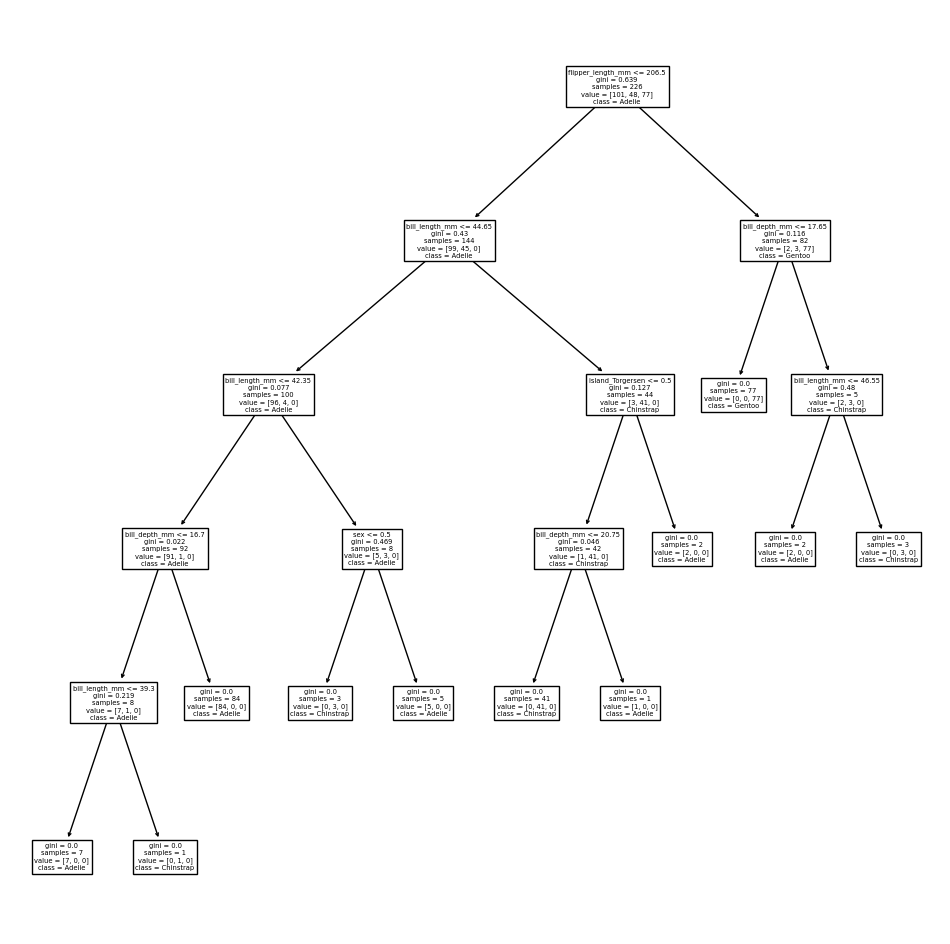

In [42]:
plt.figure(figsize=(12, 12))  # set plot size (denoted in inches)
plot_tree(clf,
          feature_names=list(X.columns),
          class_names=['Adelie', 'Chinstrap', 'Gentoo'])

We dropped 11 rows with missing values in the sex column, but it turns out that this column wasn't used. Maybe we could just drop the whole column and keep the rows that had data in the other columns. This would give us a little more data and might help to improve accuracy further.

### Gini impurity

In [43]:
from collections import Counter

def gini_impurity(values):
    """
    Calculate the Gini impurity for a list of values.
    
    Args:
    values (list): A list of categorical values.
    
    Returns:
    float: The Gini impurity of the list.
    """
    counts = Counter(values)
    total = len(values)
    impurity = 1.0

    for label in counts:
        prob_of_label = counts[label] / total
        impurity -= prob_of_label ** 2
    return impurity

In [44]:
labels = ['Gentoo', 'Gentoo', 'Adelie', 'Chinstrap']
#labels = ['Gentoo', 'Gentoo', 'Adelie', 'Adelie']
#labels = ['Gentoo', 'Gentoo', 'Gentoo', 'Gentoo']

gini_impurity(labels)

0.625